In [1]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
import seaborn as sbn
import pandas as pd
from datetime import datetime
import time
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from pandas.api.types import CategoricalDtype

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('default') 
sbn.set(style="whitegrid") 

In [2]:
def postulantes_str2timestamp(s): # debo
    if type(s) is datetime:
        return s
    try:
        return datetime.strptime(s, '%Y-%m-%d')
    except:
        return None
def sanitize_postulante_genero_edad(df):
    df['sexo'] = df['sexo'].astype('category').fillna("NO_DECLARA")
    df = df.drop_duplicates(subset='idpostulante')
    df['fechanacimiento']= df['fechanacimiento'].map(postulantes_str2timestamp)
    mean_datetime = datetime.now()
    df['fechanacimiento']= df['fechanacimiento'].map(lambda it: it if it else mean_datetime)
    df['edad'] = df.fechanacimiento.apply(lambda it: 2018 - it.year)
    df = df[df.edad >17][df.edad<105]
    return df.drop(['fechanacimiento'],1)
def generar_nivel_educativo(postulantes, educacion):
    #Considero como nivel educativo el maximo nivel que alcanzaron que fue completado.
    #Descarto estudios en curso o abandonados, quizas deba volver aca en algun momento
    tipo_estudio = CategoricalDtype(
        categories=["Otro","Secundario","Terciario/Técnico","Universitario","Posgrado","Master","Doctorado"],
        ordered=True
    )
    educacion = educacion[educacion.estado=='Graduado'].drop(['estado'],1)
    educacion.nombre= educacion.nombre.astype(tipo_estudio)
    educacion = educacion.sort_values(by='nombre',ascending=True)
    educacion = educacion.drop_duplicates(subset='idpostulante',keep='last')
    postulantes = postulantes.merge(educacion, on='idpostulante')
    postulantes = postulantes.rename(index=str,columns={'nombre':'nivel_educativo'})
    return postulantes.copy()
def satinizar_vistas(vistas):
    return vistas.drop_duplicates().rename(columns={'idAviso': 'idaviso'})

def sanitize_aviso_detalle(df):
    tipo_trabajo = CategoricalDtype(
        categories=["Full-time","Part-time","Teletrabajo","Por Horas","Pasantia","Temporario","Por Contrato","Fines de Semana","Primer empleo"],
        ordered=True #de 'mas fijo' a 'menos fijo'
    )
    df['tipo_de_trabajo'] = df['tipo_de_trabajo'].astype(tipo_trabajo)
    # el numero quizas amerite tratarse como hiperparametro
    empresas_reconocidas = df.denominacion_empresa.value_counts().index[:100]
    df.loc[:,'denominacion_empresa'] = df.denominacion_empresa.apply(lambda it: it if it in empresas_reconocidas else 'Otro')
    for columna in ['nombre_zona','nombre_area','denominacion_empresa','nivel_laboral']:
        df.loc[:,columna] = df.loc[:,columna].astype('category')
    df.nivel_laboral = df.nivel_laboral.fillna('Otro')
    df.denominacion_empresa = df.denominacion_empresa.fillna('Otro')
    df = df.drop_duplicates(subset='idaviso')
    return df.drop(['ciudad','idpais','mapacalle'],1)
def sanitize_postulaciones(df):
    df['date'] = pd.to_datetime(df['fechapostulacion']).dt.date
    df['time'] = pd.to_datetime(df['fechapostulacion']).dt.time
    return df
def agregar_cantidad_anuncios(df, nombre_columna, anuncios):
    values = pd.DataFrame()
    value_counts = anuncios['idpostulante'].value_counts()
    values['idpostulante'] = value_counts.index
    values[nombre_columna] = value_counts.values
    df = pd.merge(df,values, on='idpostulante',how='left')
    df[nombre_columna] = df[nombre_columna].fillna(0)
    return df

In [3]:
#Antes que nada, me intriga si los archivos de 'datos_navent' y los de 'hasta15/4' tienen overlap, son redundantes o consecutivos
def leer_datos_entrenamiento():
    genero_edad_postulantes = pd.read_csv(
        'datos/datos_navent/fiuba_2_postulantes_genero_y_edad.csv'
    ).merge(
        pd.read_csv('datos/hasta_15_4/fiuba_2_postulantes_genero_y_edad.csv'),
        on=['idpostulante','fechanacimiento','sexo'],
        how='outer'
    )
    #veo que hay repetidos por id
    #veo que hay gente (4) con sexo '0'
    # Genero una funcion para satinizar archivos de postulantes_genero_edad
    genero_edad_postulantes = sanitize_postulante_genero_edad(genero_edad_postulantes)
    educacion_postulantes = pd.read_csv(
        'datos/datos_navent/fiuba_1_postulantes_educacion.csv'
    ).merge(pd.read_csv('datos/hasta_15_4/fiuba_1_postulantes_educacion.csv'))
    postulantes = generar_nivel_educativo(genero_edad_postulantes, educacion_postulantes)
    vistas = pd.concat([
        pd.read_csv('datos/hasta_15_4/fiuba_3_vistas.csv'),
        pd.read_csv('datos/datos_navent/fiuba_3_vistas.csv')
    ])
    vistas = satinizar_vistas(vistas)
    vistas.idaviso = vistas.idaviso.astype('int64')
    postulantes = agregar_cantidad_anuncios(postulantes, 'anuncios_vistos', vistas)
    postulaciones = pd.read_csv(
        'datos/datos_navent/fiuba_4_postulaciones.csv'
    ).merge(pd.read_csv('datos/hasta_15_4/fiuba_4_postulaciones.csv'))
    postulaciones = sanitize_postulaciones(postulaciones)
    avisos_detalle = pd.concat([
        pd.read_csv('datos/datos_navent/fiuba_6_avisos_detalle.csv'),
        pd.read_csv('datos/hasta_15_4/fiuba_6_avisos_detalle.csv'),
        pd.read_csv('datos/fiuba_6_avisos_detalle_missing_nivel_laboral.csv')
    ])
    #ESTE DF TIENE MUCHOS DATOS NULOS EN LAS COLUMNAS DE 'CIUDAD' y 'MAPACALLE'. 
    #Decidimos eliminarlas ya que no nos parecieron muy relevantes para el analisis
    #idpais solo tiene valor 1, la descripcion nunca es nula
    #avisos_detalle.drop('descripcion',1,inplace=True)
    avisos_detalle.nombre_area.value_counts()# hay muchas areas, no van a tener su propia categoria
    avisos_detalle = sanitize_aviso_detalle(avisos_detalle)
    return postulantes, avisos_detalle, vistas, postulaciones

In [4]:
def leer_datos_predicciones():
    postulantes = sanitize_postulante_genero_edad(pd.read_csv('datos/desde_15_4/fiuba_2_postulantes_genero_y_edad.csv'))
    postulantes = generar_nivel_educativo(postulantes, pd.read_csv('datos/desde_15_4/fiuba_1_postulantes_educacion.csv'))
    vistas = satinizar_vistas(pd.read_csv('datos/desde_15_4/fiuba_3_vistas.csv'))
    postulantes = agregar_cantidad_anuncios(postulantes, 'anuncios_vistos', vistas)
    avisos = sanitize_aviso_detalle(pd.concat([
        pd.read_csv('datos/desde_15_4/fiuba_6_avisos_detalle.csv'),
        pd.read_csv('datos/fiuba_6_avisos_detalle_missing_nivel_laboral.csv')#
    ]))
    template_submit = pd.read_csv('datos/template_resultado.csv')
    return postulantes, avisos, vistas, template_submit

In [5]:
#postulantes, avisos_detalle, vistas, postulaciones = leer_datos_entrenamiento()
postulantes, avisos_detalle, vistas, submit = leer_datos_predicciones()

/home/vasectomio/.virtualenv/datos/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


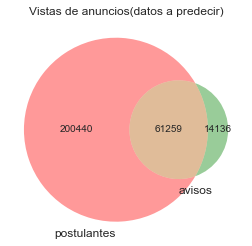

In [10]:
anuncios = avisos_detalle.drop_duplicates(subset=['idaviso'])
usuarios = postulantes.drop_duplicates(subset=['idpostulante'])
union = submit.merge(usuarios, on='idpostulante',how='inner').merge(anuncios, on='idaviso',how='inner')

venn2(subsets=(usuarios.shape[0],anuncios.shape[0],union.shape[0]), set_labels=('postulantes','avisos'))
plt.title('Vistas de anuncios(datos a predecir)')
plt.show()
del anuncios, usuarios, union

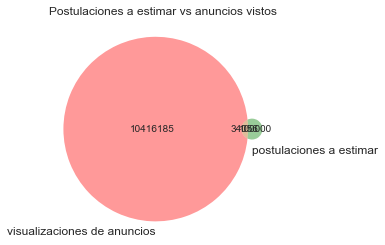

<Figure size 1440x1440 with 0 Axes>

In [25]:
venn2(
    subsets=(
        vistas.drop_duplicates().shape[0],
        submit.drop_duplicates().shape[0],
        vistas.merge(submit, how='inner',on=['idpostulante','idaviso']).drop_duplicates(subset=['idpostulante','idaviso']).shape[0]
    ), set_labels=('visualizaciones de anuncios','postulaciones a estimar')
)
plt.title('Postulaciones a estimar vs anuncios vistos')
plt.figure(figsize=(20,20))
plt.show()

# Algunas exploraciones de cada archivo por separado

In [ ]:
#Distribución de las postulaciones por dia del mes
g_day = pd.to_datetime(postulaciones['date']).dt.day.hist(bins=31,edgecolor='black');
g_day.set_title('Disitribucion de las postulaciones por día del mes',fontsize=15)
g_day.set_xlabel('Dia')
g_day.set_ylabel('Cantidad de postulaciones');

In [ ]:
# ¿Será que uno se pone a buscar trabajo cuando se le empieza a acabar el sueldo?
g_day = pd.to_datetime(postulaciones['date']).dt.day.hist(bins=4,edgecolor='black');

In [ ]:
enero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 1]
enero = pd.DataFrame(enero)

febrero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]
febrero = pd.DataFrame(febrero)

sizes = [enero.count(),febrero.count()]
names = ['Enero', 'Febrero']

plt.figure(figsize=(3, 3))
plt.title('Distribucion de las postulaciones por mes', fontsize=15)
plt.pie(sizes, labels=names, autopct='%1.1f%%', startangle=90, colors=['green', 'lightblue'], explode=(0.1, 0),shadow=True)
plt.show()

In [ ]:
# ¡Los datos empiezan a partir del 15/1!
postulaciones['date'].min()

Ambos graficos son engañosos.
El primero muestra que hay mas postulaciones en la segunda mitad de los meses pero eso es porque los datos de Enero son solo de la segunda mitad del mes.
De igual manera el sugundo grafico muestra que Enero tiene practicamente la mitad de postulaciones que Febrero.
Tambien se debe a lo comentado anteriormente, solo hay datos de la segunda mitad de Enero.

In [ ]:
#Febrero tiene (casi)los dias completos
febrero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]
febrero = pd.DataFrame(febrero.unique()).sort_values(by=0, ascending=False)
febrero

In [ ]:
g_month_enero = pd.to_datetime(postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 1]).dt.day.hist(bins=17,edgecolor='black');
g_month_enero.set_title('Distribucion de postulaciones durante Enero',fontsize=15)
g_month_enero.set_xlabel('Dias')
g_month_enero.set_ylabel('Cantidad de postulaciones');

In [ ]:
g_month_febrero = pd.to_datetime(postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]).dt.day.hist(bins=28,edgecolor='black');
g_month_febrero.set_title('Distribucion de postulaciones durante Febrero',fontsize=15)
g_month_febrero.set_xlabel('Dias')
g_month_febrero.set_ylabel('Cantidad de postulaciones');

Ambos gráficos presentan 'bajones' de 2-3 días de duración: ¿Son fines de semana

In [ ]:
postulaciones['weekday']= pd.to_datetime(postulaciones['date']).dt.dayofweek
days = ['lunes','martes','miercoles','jueves','viernes','sabado','domingo']
postulaciones['weekday'] = pd.Categorical(values=postulaciones['weekday'].values, ordered=True).rename_categories(days)
postulaciones['weekday'].value_counts().sort_index().plot(kind='bar', title='Postulaciones por dia de semana')
# Al hacer el gráfico, podemos ver que los fines de semana tienen muchas menos postulaciones
# y que jueves y viernes son los dias de la semana con menos postulaciones.

In [ ]:
#este df contiene solo los dias entre el 15 y 28 de cada mes
enero_febrero_igual_dias = pd.DataFrame(columns = ['date'])
enero_febrero_igual_dias['date'] = postulaciones['date'][(pd.to_datetime(postulaciones['date']).dt.day > 14) & (pd.to_datetime(postulaciones['date']).dt.day < 29)]

In [ ]:
hist_enero_edit = pd.to_datetime(enero_febrero_igual_dias['date'][pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 1]).dt.day.hist(bins=13,color= 'lightgreen');
hist_enero_edit.set_title('Distribucion de postulaciones durante Enero(15-28)',fontsize=15)
hist_enero_edit.set_xlabel('Dias')
hist_enero_edit.set_ylabel('Cantidad de postulaciones');

In [ ]:
hist_Febrero_edit = pd.to_datetime(enero_febrero_igual_dias['date'][pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 2]).dt.day.hist(bins=13,color='lightblue');
hist_Febrero_edit.set_title('Distribucion de postulaciones durante Febrero(15-28)',fontsize=15)
hist_Febrero_edit.set_xlabel('Dias')
hist_Febrero_edit.set_ylabel('Cantidad de postulaciones');

In [ ]:
plt.hist(pd.to_datetime(enero_febrero_igual_dias['date']
        [pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 2]).dt.day, bins=13,
         color='lightblue',label= 'Febrero')
plt.hist(pd.to_datetime(enero_febrero_igual_dias['date']
        [pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 1]).dt.day,bins=13,
         color='violet',alpha=0.5, label='Enero')
plt.xlabel('Fechas')
plt.ylabel('Cantidad de postulaciones')
plt.title('Distribucion de las postulaciones entre el 15 y 28 de cada mes')
plt.legend()
plt.show()

De esta última comparación se aprecia que el número de postulaciones es en general
mayor para febrero, y que el último día de febrero presenta un pico muy alto en 
las postulaciones.

In [ ]:
edad_postulantes = pd.DataFrame(columns=['edad'])
edad_postulantes['edad'] = postulantes['edad'][(postulantes['edad'] > 17) & (postulantes['edad'] < 71)]
edad_postulantes['edad'] = edad_postulantes['edad'].astype(int)
edad_postulantes.sort_values(by='edad', ascending = True)

In [ ]:
post_genero = postulantes['sexo'].value_counts().plot(kind='barh')
post_genero.set_title('Distribucion de postulantes segun el genero',fontsize=15)
post_genero.set_ylabel('Genero')
post_genero.set_xlabel('Cantidad de postulaciones');

In [ ]:
post_edad = edad_postulantes['edad'].value_counts().sort_index().plot(kind='line',color='green')
post_edad.set_title('Distribucion de postulaciones segun la edad de los postulantes',fontsize=15)
post_edad.set_xlabel('Edad')
post_edad.set_ylabel('Cantidad de postulaciones');



In [ ]:
plt.hist(postulantes[postulantes.sexo == 'FEM'].edad, bins='auto' ,color='pink',label= 'Postulantes Fememinas')
plt.hist(postulantes[postulantes.sexo == 'MASC'].edad,bins='auto',color='darkblue',alpha=0.3, label='Postulantes Masculinos')
plt.hist(postulantes[postulantes.sexo == 'NO_DECLARA'].edad,bins='auto',color='red',alpha=0.5, label='Postulantes sin sexo declarado')

plt.xlabel('Edad')
plt.ylabel('Cantidad de postulaciones')
plt.title('Distribucion de las postulaciones segun edad y el genero')
plt.xlim((15,80))
plt.legend()
plt.show()

In [ ]:
#avisos_nivel_laboral = avisos_detalle['nivel_laboral'].value_counts().plot(kind='bar')
#avisos_nivel_laboral.set_title('Distribucion de los avisos laborales segun el nivel laboral pedido',fontsize=15)
#avisos_nivel_laboral.set_xlabel('Cantidad de avisos')
#avisos_nivel_laboral.set_ylabel('Nivel laboral');

avisos_detalle#['nivel_laboral'].value_counts()

In [ ]:
avisos_tipo_de_trabajo = np.log(avisos_detalle['tipo_de_trabajo'].value_counts()+1).plot(kind='barh')
avisos_tipo_de_trabajo.set_title('Distribucion de los avisos (log) laborales segun el tipo de trabajo pedido',fontsize=15)
avisos_tipo_de_trabajo.set_ylabel('Tipo de trabajo')
avisos_tipo_de_trabajo.set_xlabel('Cantidad de avisos (log)');

avisos_detalle['tipo_de_trabajo'].value_counts().sum()

In [ ]:
avisos_zona = np.log(avisos_detalle['nombre_zona'].value_counts() + 1).sort_index().plot(kind='bar')
avisos_zona.set_title('Distribucion de los avisos laborales segun la zona de trabajo',fontsize=15)
avisos_zona.set_xlabel('Zona')
avisos_zona.set_ylabel('Cantidad de avisos (log)');

avisos_detalle['nombre_zona'].value_counts()

# Merge de los datos
recuerdo la forma de los datasets

In [ ]:
hist_educacion = postulantes['nivel_educativo'].value_counts().plot(logy=True, kind='bar')
hist_educacion.set_title('Cantidad de postulantes por nivel educativo')
hist_educacion.set_xlabel('Nivel educativo')
hist_educacion.set_ylabel('Cantidad de postulantes(log)')

In [ ]:
scatter_anuncios_vistos = postulantes.groupby('nivel_educativo').mean()['anuncios_vistos'].plot(kind='bar')
scatter_anuncios_vistos.set_title('Cantidad de anuncios vistos por nivel educativo')
scatter_anuncios_vistos.set_xlabel('Nivel educativo')
scatter_anuncios_vistos.set_ylabel('Cantidad de anuncios vistos por postulante(media)')